In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model

import model2 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss
from lovasz_loss import lovasz_hinge_flat

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

# Setup Dataset

In [4]:
train_df, val_df, _ = get_dfs()

In [5]:
train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True, with_aux_label=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34HcAux(n_classes=1, pretrained_resnet=True)
model = model.to(device)

#criterion = lovasz_hinge_flat
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Loaded pretrained resnet weights


In [7]:
def criterion(logit_pixel, logit_feat, target_pixel, target_label):
    pixel_loss = F.binary_cross_entropy_with_logits(logit_pixel.view(-1), target_pixel.view(-1), size_average=True)
    classification_loss = F.cross_entropy(logit_feat, target_label)
    
    return pixel_loss + 0.1 * classification_loss

In [8]:
def train(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit_pixel, logit_feat = model(data)
            loss = criterion(logit_pixel, logit_feat, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            #iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [9]:
model = train(model, 20, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-07 22:16:34.792187] Train Epoch: 0 [0/3200 (0%)]	Average loss: 0.046363
[2018-10-07 22:16:53.494971] Train Epoch: 0 [800/3200 (25%)]	Average loss: 0.042469
[2018-10-07 22:17:12.259996] Train Epoch: 0 [1600/3200 (50%)]	Average loss: 0.039532
[2018-10-07 22:17:31.010295] Train Epoch: 0 [2400/3200 (75%)]	Average loss: 0.037650
[2018-10-07 22:17:31.010295] Train Epoch: 0	IoU: 0.368500
[2018-10-07 22:18:04.618910] Train Epoch: 1 [0/3200 (0%)]	Average loss: 0.027323
[2018-10-07 22:18:23.760301] Train Epoch: 1 [800/3200 (25%)]	Average loss: 0.028653
[2018-10-07 22:18:42.924231] Train Epoch: 1 [1600/3200 (50%)]	Average loss: 0.026825
[2018-10-07 22:19:02.074480] Train Epoch: 1 [2400/3200 (75%)]	Average loss: 0.026546
[2018-10-07 22:19:02.074480] Train Epoch: 1	IoU: 0.561500
[2018-10-07 22:19:29.339872] Train Epoch: 2 [0/3200 (0%)]	Average loss: 0.023051
[2018-10-07 22:19:48.492797] Train Epoch: 2 [800/3200 (25%)]	Average loss: 0.022916
[2018-10-07 22:20:07.678144] Train Epoch: 2 [1600

In [10]:
save_model(model, 'unet_res34_hcaux')

In [11]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


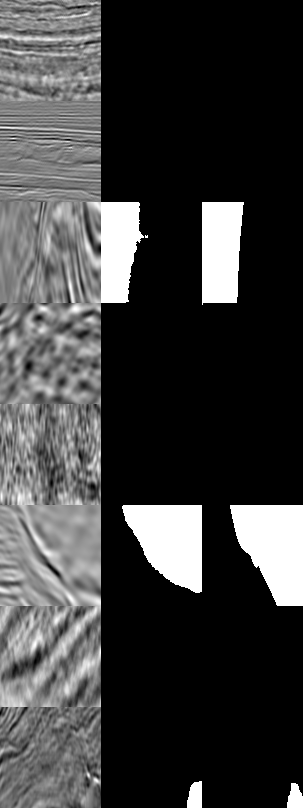

In [12]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


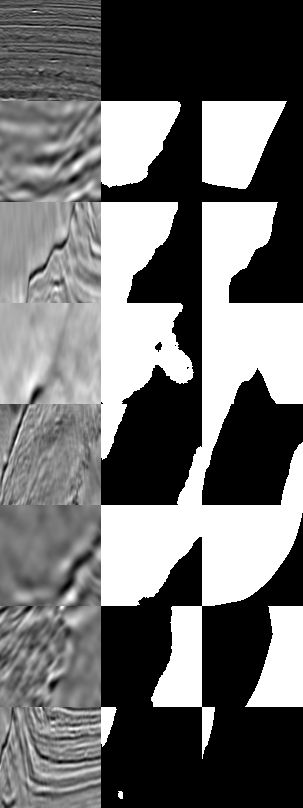

In [13]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


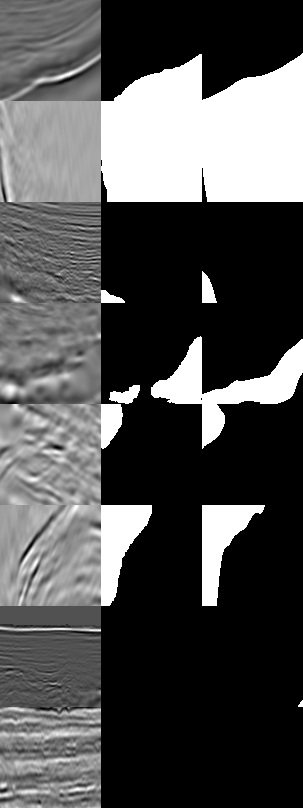

In [14]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


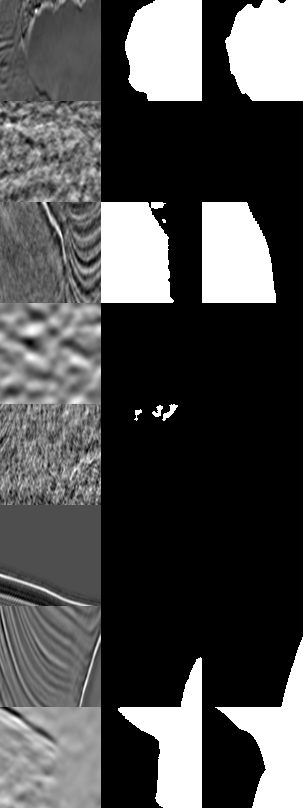

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)